In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=2.0)
import torch

from botorch.models import SingleTaskGP
from gpytorch.kernels import RQKernel, RBFKernel

In [162]:
N = 60
nv = 40
full_x = torch.cat((torch.linspace(-3, 5, N - nv), torch.linspace(-10, 10, nv))).view(-1,1)
# full_x = torch.linspace(-3, 5, N).view(-1,1)
m2 = SingleTaskGP(full_x, torch.randn(N, 1), covar_module=RQKernel(alpha = 0.5))

In [163]:
full_y = m2(full_x).sample()

In [169]:
# indices = torch.randperm(N)
# train_x = full_x[indices[:N]]
# train_y = full_y[indices[:N]]

# calib_x = full_x[indices[N-nv:]]
# calib_y = full_y[indices[N-nv:]]
train_x = full_x[:(N - nv)]
train_y = full_y[:(N - nv)]

calib_x = full_x[(N - nv):]
calib_y = full_y[(N - nv):]

In [170]:
m2.set_train_data(train_x, train_y.squeeze(), strict=False)

In [171]:
m1 = SingleTaskGP(train_x, train_y.view(-1,1), covar_module=RBFKernel())
m1.likelihood.noise = 0.2

In [172]:
m3 = SingleTaskGP(train_x, train_y.view(-1,1), covar_module=RQKernel(alpha = 0.5))
m3.likelihood.noise = 0.2

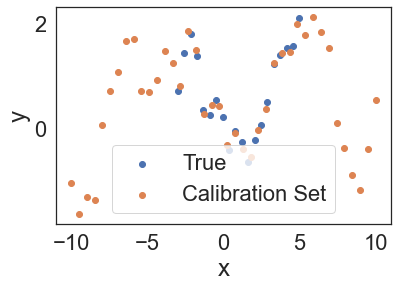

In [173]:
plt.scatter(train_x, train_y, label = "True")
plt.scatter(calib_x, calib_y, label = "Calibration Set")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [174]:
from botorch.acquisition import ExpectedImprovement

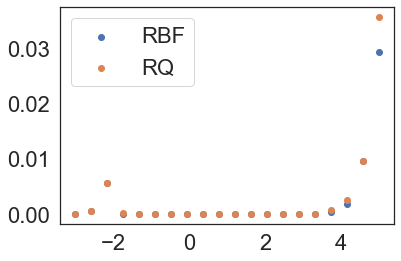

In [175]:
plt.scatter(train_x, ExpectedImprovement(m1, train_y.max())(train_x.unsqueeze(-2)).detach(), label = "RBF")
plt.scatter(train_x, ExpectedImprovement(m3, train_y.max())(train_x.unsqueeze(-2)).detach(), label = "RQ")
plt.legend()


In [176]:
def get_scores(m):
    m_post = m.posterior(calib_x)
    return torch.abs(m_post.mean.squeeze() - calib_y.squeeze()) / m_post.variance.pow(0.5).squeeze()

In [177]:
get_scores(m1)

tensor([1.0374, 1.6299, 1.2989, 1.3566, 0.0616, 0.7186, 1.0837, 1.6750, 1.7121,
        0.7089, 0.7073, 0.9396, 1.6259, 1.6235, 0.6889, 0.8826, 0.7673, 0.8493,
        0.4283, 0.5871, 0.8726, 0.4871, 0.1601, 0.4774, 0.2232, 0.3835, 0.5838,
        0.2809, 0.3078, 0.7637, 0.5332, 1.5341, 1.6323, 1.5063, 0.1135, 0.3683,
        0.8724, 1.1660, 0.3851, 0.5439], grad_fn=<DivBackward0>)

In [178]:
test_x = torch.linspace(-10, 10, 1000).view(-1,1).unsqueeze(-2)

In [179]:
batch_ei = (m1.posterior(test_x).sample(torch.Size((4096,))) - train_y.max().unsqueeze(-1)).clamp_min(0.).max(dim=-1)[0].mean(dim=0)

In [180]:
batch_ei_rq = (m3.posterior(test_x).sample(torch.Size((4096,))) - \
               train_y.max().unsqueeze(-1)).clamp_min(0.).max(dim=-1)[0].mean(dim=0)

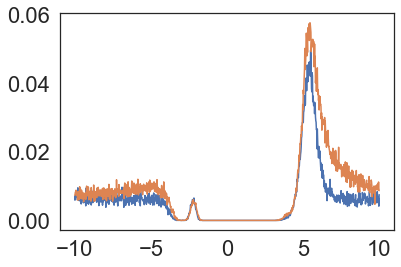

In [181]:
plt.plot(test_x.squeeze(), batch_ei.squeeze())
plt.plot(test_x.squeeze(), batch_ei_rq.squeeze())

In [182]:
def conformal_ei(m, samples = 4096):
    scores = get_scores(m)
    # calibration set is of size 50
    # qhats = torch.quantile(scores, torch.ceil(51 * (1 - alphas)).squeeze() / 50)
    qhat = torch.quantile(scores, (torch.ceil(51 * torch.rand(samples)) / 50).clamp(min=0, max=1.))
    
    m_post = m.posterior(test_x)
    scaling = m_post.variance.squeeze(-1).unsqueeze(0) * qhat.unsqueeze(-1).unsqueeze(-1)
    conformal_samples = torch.rand_like(scaling) * 2 * scaling + m_post.mean.squeeze(-1).unsqueeze(0) - scaling

    # now we're uniform on the interval [\mu - scalings, \mu + scalings]
#     scalings = m_post.variance * qhats
#     conformal_samples = torch.rand_like(scalings) * 2 * scalings + m_post.mean
#     conformal_samples = conformal_samples.permute(2, 0, 1)
    conformal_ei = (conformal_samples - train_y.max()).clamp_min(0.).max(dim=-1)
    return conformal_ei[0].mean(dim=0)

[]

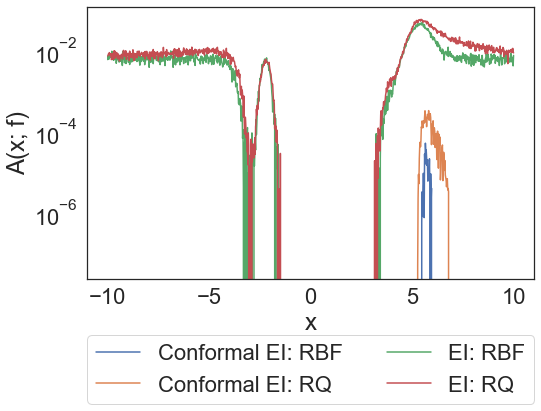

In [183]:
plt.figure(figsize = (8, 5))
plt.plot(test_x.squeeze(), conformal_ei(m1).detach(), label = "Conformal EI: RBF")
plt.plot(test_x.squeeze(), conformal_ei(m3).detach(), label = "Conformal EI: RQ")
plt.plot(test_x.squeeze(), batch_ei.squeeze(), label = "EI: RBF")
plt.plot(test_x.squeeze(), batch_ei_rq.squeeze(), label = "EI: RQ")
plt.legend(ncol = 2, loc = "lower center", bbox_to_anchor = (0.5, -0.5))
plt.xlabel("x")
plt.ylabel("A(x; f)")
plt.semilogy()

[]

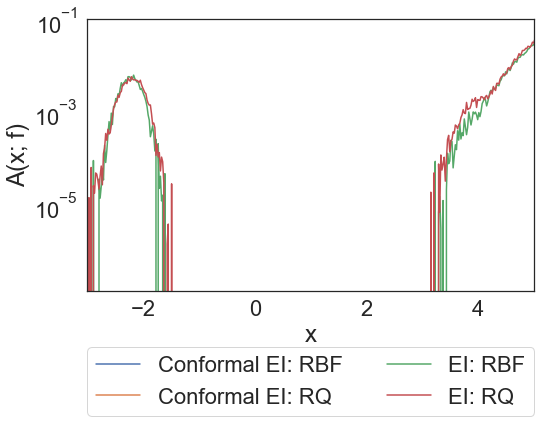

In [184]:
plt.figure(figsize = (8, 5))
plt.plot(test_x.squeeze(), conformal_ei(m1).detach(), label = "Conformal EI: RBF")
plt.plot(test_x.squeeze(), conformal_ei(m3).detach(), label = "Conformal EI: RQ")
plt.plot(test_x.squeeze(), batch_ei.squeeze(), label = "EI: RBF")
plt.plot(test_x.squeeze(), batch_ei_rq.squeeze(), label = "EI: RQ")
plt.legend(ncol = 2, loc = "lower center", bbox_to_anchor = (0.5, -0.5))
plt.xlabel("x")
plt.ylabel("A(x; f)")
plt.xlim((train_x.min(), train_x.max()))
plt.semilogy()

In [185]:
    samples = 4096
    scores = get_scores(m3)
    # calibration set is of size 50
    # qhats = torch.quantile(scores, torch.ceil(51 * (1 - alphas)).squeeze() / 50)
    qhat = torch.quantile(scores, (torch.ceil(51 * torch.rand(samples)) / 50).clamp(min=0, max=1.))
    
    m_post = m3.posterior(test_x)
    scaling = m_post.variance.squeeze(-1).unsqueeze(0) * qhat.unsqueeze(-1).unsqueeze(-1)
    conformal_samples = torch.rand_like(scaling) * 2 * scaling + m_post.mean.squeeze(-1).unsqueeze(0) - scaling

In [186]:
lower = torch.quantile(conformal_samples, 0.025, dim=-3).squeeze().detach()
upper = torch.quantile(conformal_samples, 0.975, dim=-3).squeeze().detach()

In [187]:
gp_lower = (m_post.mean - 2 * m_post.variance.sqrt()).squeeze().detach()
gp_upper = (m_post.mean + 2 * m_post.variance.sqrt()).squeeze().detach()


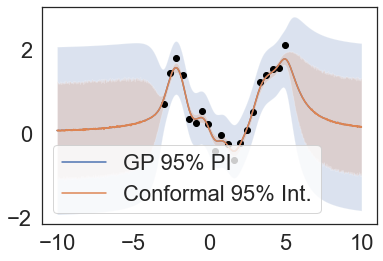

In [188]:
plt.plot(test_x.squeeze(), m_post.mean.detach().squeeze(), label = "GP 95% PI")
plt.fill_between(test_x.squeeze(), gp_lower, gp_upper, alpha = 0.2)

plt.plot(test_x.squeeze(), conformal_samples.mean(0).detach(), label = "Conformal 95% Int.")
plt.fill_between(test_x.squeeze(), lower, upper, alpha = 0.2)

plt.scatter(train_x, train_y, color = "black")
plt.legend()

In [144]:
(conformal_samples - train_y.max()).clamp_min(0).sum()

tensor(0., grad_fn=<SumBackward0>)

In [145]:
mean = conformal_samples.mean(dim=0)
ucb_samples = mean + 0.01 * (conformal_samples - mean).abs()
ucb_output = ucb_samples.max(dim=-1)[0].mean(dim=0)

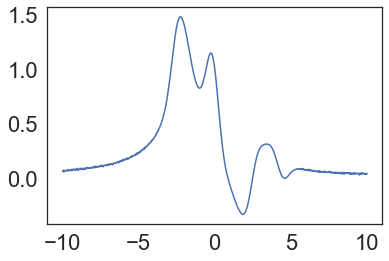

In [146]:
plt.plot(test_x.squeeze(), ucb_output.detach())

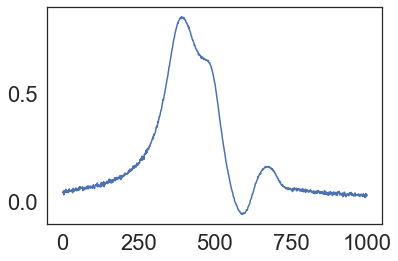

In [123]:
plt.plot(mean.detach())